In [ ]:
# Training and validating pipeline for the QSM 3D segmentation project 
# Course: cs512
# instructor: Gady Agam
# Group 1: 
# Rasheed Abid, rabid@hawk.iit.edu
# Khalid Saifullah, ksaifullah@hawk.iit.edu

In [ ]:
# This is the training portion of our code. 
# As we are unable to upload the dataset, we are providing with the fully training model, with all it's output. 
# The model is also saved in the folder "saved_models"

In [ ]:
# installations if required
!pip install SimpleITK
!pip install patchify
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports
import os
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

from skimage import io
from sklearn.model_selection import train_test_split

from patchify import patchify, unpatchify

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, Concatenate, add, Input, BatchNormalization

print("Tensorflow version = " + tf.__version__)
print("Keras version = " + keras.__version__)

import os
import nibabel as nib
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


Tensorflow version = 2.12.0
Keras version = 2.12.0


In [ ]:
# incase of running on google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# changing variables # this is the only section that needs to be changed for trainging. 
# As we had many different files and numbers we had these numbers available. All these numbers are not availble during testing phases, only a subset of it.


maindir = "/Users/rashid_abid/Desktop/CS512_Computer_Vision/Project_proposal/final_project_draft2"
subject_num = 80 # available ones are 32, 64, 80, 100
subject_num_testing = 20 # available ones are 9, 20
label_name = "amygdala" # available ones are "amygdala", "caudate", "hippocampus", "putamen", "thalamus"
epochs = 50
dim = 128
n_classes = 1
model_to_run = "unet" # available ones are "res_unet" and "unet"

# architecture parameters
patch_size = 64 # testing with 64x64x64 patches
channels=1

LR = 0.0001 # Learning rate
optim = keras.optimizers.Adam(LR)

In [ ]:
# directories 

os.chdir( maindir )
source_dir = os.path.join(maindir, "data_dir")
results_dir = os.path.join(maindir, "results_dir")
files_dir = os.path.join(maindir, "files")
scripts_dir = os.path.join(maindir, "scripts")

In [ ]:
# file names
saved_model_name = label_name + "_mask_dim" + str(dim) + "_sub" + str(subject_num) + "_e" + str(epochs) + ".h5"
saved_model_name = os.path.join(results_dir, "saved_models", saved_model_name)

subject_filename = "filename_sub" + str(subject_num) + ".txt"
filename = os.path.join(files_dir, subject_filename)

# check if the folder exists
if not os.path.exists(os.path.join(results_dir, "saved_models") ):
    os.makedirs(os.path.join(results_dir, "saved_models") )

print("Model will be saved in:\n" + saved_model_name)

/content/drive/MyDrive/Colab Notebooks/CS512/project/results_dir/saved_models/brain_mask_mask_dim128_sub80_e50_checking_new_model_.h5


In [ ]:
# suffix selection for images
if dim == 256:
    Suffix = 2
elif dim ==  128:
    Suffix = 4
else:
    Suffix = 8

print( "Suffix for the files is = %d" %Suffix )

Suffix for the files is = 4


In [ ]:
# Generate a unet with skip connections for our model


def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)
    return x

#Encoder block:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    f1 = conv_block(d4, 32)
    
    if n_classes == 1:  # For singular mask checking
      activation = 'sigmoid'
    else: # for multilevel label checking
      activation = 'softmax'

    outputs = Conv3D(n_classes, 1, padding="same", activation=activation)(f1)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="UNet")
    return model

In [ ]:
def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv3D(filters=nb_filters[0], kernel_size=(3, 3, 3), padding="same", strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv3D(filters=nb_filters[1], kernel_size=(3, 3, 3), padding="same", strides=strides[1])(res_path)

    shortcut = Conv3D(nb_filters[1], kernel_size=(1, 1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv3D(filters=64, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv3D(filters=64, kernel_size=(3, 3, 3), padding="same", strides=(1, 1, 1))(main_path)

    shortcut = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2, 2), (1, 1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2, 2), (1, 1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling3D(size=(2, 2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]])
    main_path = res_block(main_path, [256, 256], [(1, 1, 1), (1, 1, 1)])

    main_path = UpSampling3D(size=(2, 2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]])
    main_path = res_block(main_path, [128, 128], [(1, 1, 1), (1, 1, 1)])

    main_path = UpSampling3D(size=(2, 2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]])
    main_path = res_block(main_path, [64, 64], [(1, 1, 1), (1, 1, 1)])

    return main_path


def build_res_unet(input_shape, n_classes):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2, 2), (1, 1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv3D(filters=n_classes, kernel_size=(1, 1, 1), activation='sigmoid')(path)

    return Model(inputs, path)

In [ ]:
# Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# function to normalize the nifti data once converted to numpy array, and then multiply by the mask
# of the brain

def norm_nifti(img, brain_mask_data=None):
    # We are normalizing the data to be between 0 and 1
    min_value = np.min(img)
    max_value = np.max(img)
    normalized_data = (img - min_value) / (max_value - min_value)
    
    # We are multiplying the normalized data by the brain mask
    if brain_mask_data is not None:
        normalized_data = normalized_data * brain_mask_data
    
    return normalized_data

In [ ]:
filename = filename

# initialize lists to store the patches
all_img_patches = []
all_mask_patches = []
val=0

with open(filename) as f:
    for line in f:
        print("Currently processing subject number: %d" %val)
        val=val+1
        subject_id = line.strip()


        # read filenames
        imagename = os.path.join(source_dir, "sub"+ str(subject_id), "QSM_masked_dim" + str(dim) + ".nii.gz") # even though the name says mask, the files are original QSM images
        maskname = os.path.join(source_dir, "sub"+ str(subject_id), label_name + "_dim" + str(dim) + ".nii.gz") # this is the mask for the hippocampus or any other labels selected
        brain_mask_name = os.path.join(source_dir, "sub"+ str(subject_id), "QSM_brain_mask_dim" + str(dim) + ".nii.gz") # this is the brain mask of the brain


        if not (os.path.exists(imagename) and os.path.exists(maskname) and os.path.exists(brain_mask_name) ):
            print("Some files are missing")
        
        # Read images
        img = nib.load(imagename)
        img_data = img.get_fdata().astype(np.float32)
        
        # Read mask
        mask = nib.load(maskname)
        mask_data = mask.get_fdata().astype(np.float32)

        # Read brain mask
        brain_mask = nib.load(brain_mask_name)
        brain_mask_data = brain_mask.get_fdata().astype(np.float32)
        

        #Normalise using the function we wrote
        # img_data = norm_nifti(img_data) # if you don't want to use the brain mask
        img_data = norm_nifti(img_data, brain_mask_data) # if you want to use the brain mask   
             

        #Patchify the image and mask
        patches_img = patchify(img_data, (patch_size, patch_size, patch_size), step=64)  # Step=256 for 256 patches means no overlap
        patches_mask = patchify(mask_data, (patch_size, patch_size, patch_size), step=64)  # Step=256 for 256 patches means no overlap
        

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                for k in range(patches_img.shape[2]):
                    
                    #image
                    single_patch_img = patches_img[i,j,k,:,:,:]
                    all_img_patches.append(single_patch_img)
                    
                    #mask
                    single_patch_mask = patches_mask[i,j,k,:,:,:]
                    all_mask_patches.append(single_patch_mask)
        # image stacking 
        all_patched_stacked_images = np.array(all_img_patches)
        # mask stacking
        all_patched_stacked_masks = np.array(all_mask_patches)


Currently processing subject number: 0
Currently processing subject number: 1
Currently processing subject number: 2
Currently processing subject number: 3
Currently processing subject number: 4
Currently processing subject number: 5
Currently processing subject number: 6
Currently processing subject number: 7
Currently processing subject number: 8
Currently processing subject number: 9
Currently processing subject number: 10
Currently processing subject number: 11
Currently processing subject number: 12
Currently processing subject number: 13
Currently processing subject number: 14
Currently processing subject number: 15
Currently processing subject number: 16
Currently processing subject number: 17
Currently processing subject number: 18
Currently processing subject number: 19
Currently processing subject number: 20
Currently processing subject number: 21
Currently processing subject number: 22
Currently processing subject number: 23
Currently processing subject number: 24
Currently 

In [ ]:
# check the shapes
print(all_patched_stacked_images.shape)
print(all_patched_stacked_masks.shape)

(640, 64, 64, 64)
(640, 64, 64, 64)


In [ ]:
training_images = all_patched_stacked_images
training_masks = all_patched_stacked_masks

# train_test_split at 30%
# Here X_test and y_test are actually validation data
X_train, X_test, y_train, y_test = train_test_split(training_images, training_masks, test_size=0.3, random_state=0)

In [ ]:
# Loss functions and dice metrics
# both for binary and multiclass segmentation
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    smoothing_factor = 1 # to avoid division by zero
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2. * intersection + smoothing_factor) / (union + smoothing_factor)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def dice_coef_multilabel(y_true, y_pred, numLabels=1):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[...,index], y_pred[...,index])
    return dice/numLabels


In [ ]:
if model_to_run == "unet":
    model = build_unet((patch_size, patch_size, patch_size, channels), n_classes=n_classes)
elif model_to_run == "res_unet":
    model = build_res_unet((patch_size, patch_size, patch_size, channels), n_classes=n_classes)
else:
    print("Please choose a valid model. Available models are: unet, res_unet")

sigmoid


In [ ]:
model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])
print( model.summary() )

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64,   128        ['conv3d[0][0]']                 
 alization)                     32)                                                            

In [ ]:
# check all the shapes
print(model.input_shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(None, 64, 64, 64, 1)
(448, 64, 64, 64)
(448, 64, 64, 64)
(192, 64, 64, 64)
(192, 64, 64, 64)


In [ ]:
print( X_train.max() ) # 1.0 after normalization
print( X_train.min() ) # 0.0 after normalization

1.0
0.0


In [ ]:
# fit the model
print(" The model is being trained now for %d epochs" %epochs)
history = model.fit(X_train, 
                    y_train, 
                    batch_size=4, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(X_test, y_test))

 The model is being trained now for 50 epochs
Epoch 1/50
112/112 [==============================] - 116s 1s/step - loss: 0.6204 - dice_coef: 0.3796 - val_loss: 0.8677 - val_dice_coef: 0.1323
Epoch 2/50
112/112 [==============================] - 113s 1s/step - loss: 0.5179 - dice_coef: 0.4821 - val_loss: 0.8745 - val_dice_coef: 0.1255
Epoch 3/50
112/112 [==============================] - 113s 1s/step - loss: 0.4711 - dice_coef: 0.5289 - val_loss: 0.8809 - val_dice_coef: 0.1191
Epoch 4/50
112/112 [==============================] - 113s 1s/step - loss: 0.4231 - dice_coef: 0.5769 - val_loss: 0.8680 - val_dice_coef: 0.1320
Epoch 5/50
112/112 [==============================] - 113s 1s/step - loss: 0.3815 - dice_coef: 0.6185 - val_loss: 0.6315 - val_dice_coef: 0.3685
Epoch 6/50
112/112 [==============================] - 113s 1s/step - loss: 0.3411 - dice_coef: 0.6589 - val_loss: 0.4165 - val_dice_coef: 0.5835
Epoch 7/50
112/112 [==============================] - 113s 1s/step - loss: 0.3016 - 

In [ ]:
# save the model
model.save( saved_model_name )

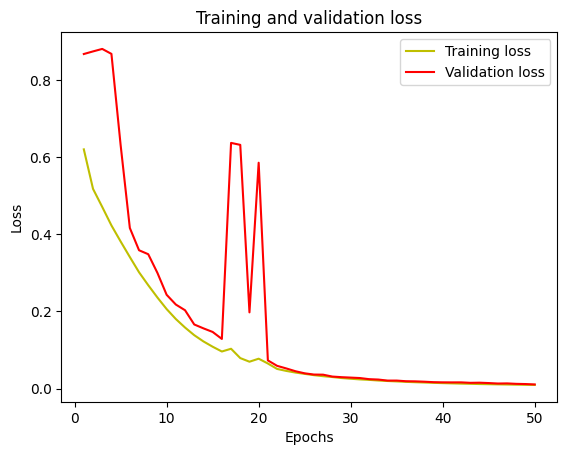

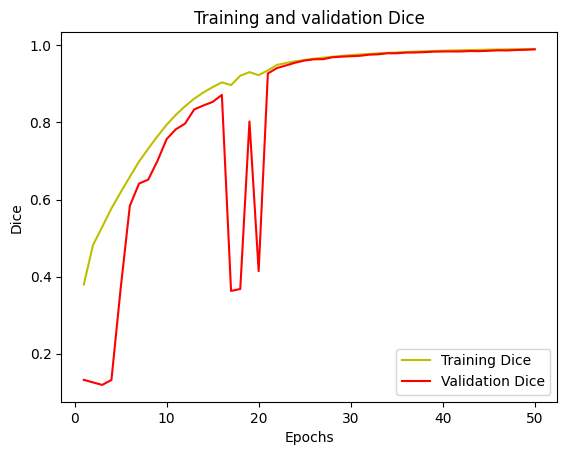

In [ ]:
# plot the traning and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


In [ ]:
# if asked, reload the model
# model = keras.models.load_model(saved_model_name)

# if the previous one is not working, try this one
my_model2 = keras.models.load_model(saved_model_name, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# predict on the validation set to visualize the results
y_pred = my_model2.predict(X_test)


In [ ]:
# check the shapes
print(y_pred.shape)
print(y_test.shape)


In [ ]:
# visualize the predicted and ground truth masks
num = 15 # image number
sl = 62 # slice number

fig, ax = plt.subplots(nrows=1, ncols=3)
im1 = ax[0].imshow(X_test[num,:, sl, :])
ax[0].set_title('Original Image patch') 
ax[0].axis("off")
fig.colorbar(im1, ax = ax[0])

x = y_pred[num, :, :, :]
im2 = ax[1].imshow(x[:, sl, :, 0])
ax[1].set_title('Predicted Mask patch')
ax[1].axis("off")
fig.colorbar(im2, ax = ax[1])


im3 = ax[2].imshow(y_test[num, :, sl, :])
ax[2].set_title('Ground Truth Mask patch')
ax[2].axis("off")
fig.colorbar(im3, ax = ax[2])

# Show the subplot
plt.show()

In [ ]:
print(y_pred.dtype)
y_pred = (y_pred>0.5).astype(np.float32)

In [ ]:
# find dice for the whole test dataset
print("Dice results for the whole validation dataset is: " + str(dice_coef(y_test, y_pred)) )
